# Age Prediction

Predicting the general age of a person based on their facial characteristics is a well-known, and still unsolved problem in machine learning. Predicting the age of a person can be useful for applications such as entertainment (providing age appropriate content), biometrics, or even just for providing a more customized user experience based on a target age.

In [236]:
!pip install -q tensorflow

In [237]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

current_directory = os.getcwd()

%matplotlib inline

## Data preparation, data cleaning, and EDA

Follow instructions in ./face-age-detection/README.md to download and unzip the dataset

In [238]:
# Read the CSV file
labels_df = pd.read_csv(current_directory + '/face-age-detection/train.csv')
labels_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


,ID,Class
count,19906,19906
unique,19906,3
top,377.jpg,MIDDLE
freq,1,10804


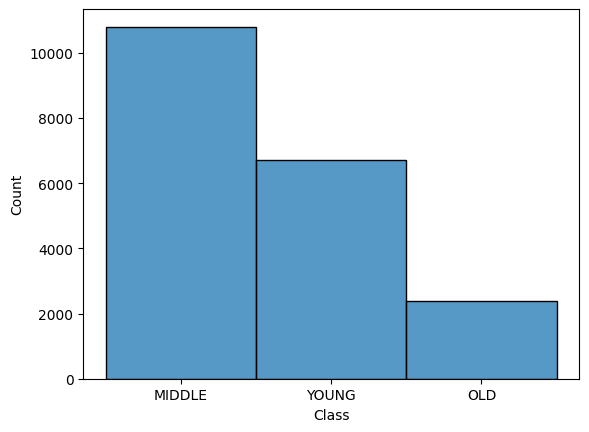

In [239]:
sns.histplot(labels_df['Class'])

print(labels_df['Class'].value_counts())

labels_df.describe()

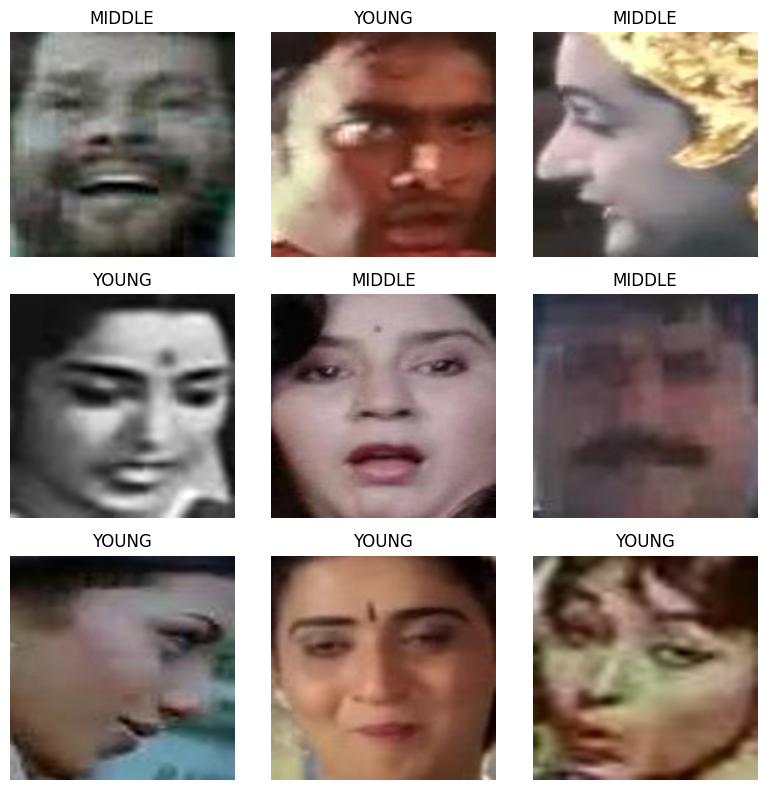

In [240]:
from tensorflow.keras.preprocessing.image import load_img
train_dir = current_directory + '/face-age-detection/Train/'

#generate a plot of 9 images (3x3 grid) with the image name and the class name below each image
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    axes = axes.flatten()
    for img, ax, label in zip( images_arr, axes, labels_arr):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get the first 9 images from the train dataset
imgs = []
labels = []
for i in range(9):
    row = labels_df.iloc[i]
    img = load_img(train_dir + row['ID'])
    #use pillow to resize the image to 150x150
    img = img.resize((299,299))
    
    imgs.append(img)
    labels.append(row['Class'])

# Plot the first 9 images
plotImages(imgs, labels)
    


## Model selection process and parameter tuning


In [241]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


SEED = 42

df_train, df_test = train_test_split(labels_df, test_size=0.4, random_state=SEED)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=SEED)

df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)


In [242]:

# train_datagen = ImageDataGenerator(
#     # rescale=1/255
# )
train_datagen = ImageDataGenerator(
    # rescale=1/255,
    
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
target_size = (150,150)

batch_size = 32

generator_args = dict(
    directory=train_dir,
    x_col='ID',
    y_col='Class',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=target_size
)
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    **generator_args
)

# Validation data generator
val_datagen = ImageDataGenerator(
    # rescale=1/255
)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    **generator_args
)

Found 11943 validated image filenames belonging to 3 classes.
Found 3982 validated image filenames belonging to 3 classes.


In [243]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)


In [244]:
def make_simple_model(learning_rate=0.1, size_inner=64,droprate=0.5,  shape = (150,150,3)):

    inputs = keras.Input(shape=shape)

    feature_map = keras.layers.Conv2D(32,(3,3), activation='relu')(inputs)

    vectors = keras.layers.MaxPooling2D(pool_size=(2,2))(feature_map)
    flattened = keras.layers.Flatten()(vectors)

    dense_layer = keras.layers.Dense(size_inner, activation='relu')(flattened)
    # drop = keras.layers.Dropout(droprate)(dense_layer)

    outputs = keras.layers.Dense(3, activation='softmax')(dense_layer)
    simple_model = keras.Model(inputs, outputs)
    # use legacy because on mac M1/M2 Adam is slow
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate
    )
    loss = keras.losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        reduction="sum_over_batch_size",
        name="categorical_crossentropy",
    )
    simple_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return simple_model


In [245]:
learning_rate = 0.001

scores = {}

for size in [100, 1000]:
    print(size)

    model = make_simple_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator)
    scores[size] = history.history

    print()
    print()

100
Epoch 1/10
374/374 [==============================] - 35s 92ms/step - loss: 45.6350 - accuracy: 0.5142 - val_loss: 1.0233 - val_accuracy: 0.5279
Epoch 2/10
 72/374 [====>.........................] - ETA: 25s - loss: 1.0128 - accuracy: 0.5421

KeyboardInterrupt: 

In [ ]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

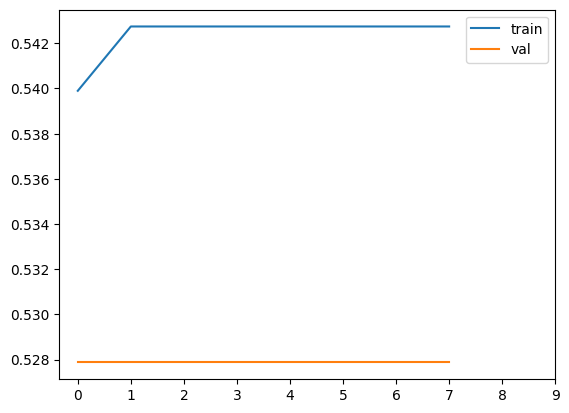

In [ ]:
# plt.plot(simple_model_history.history['accuracy'], label=('train'))
# plt.plot(simple_model_history.history['val_accuracy'], label=('val'))

# plt.xticks(np.arange(10))
# plt.legend()

In [ ]:
# train_datagen = ImageDataGenerator(
#     rescale=1/255,
    
#     rotation_range=50,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# # Training data generator
# train_generator = train_datagen.flow_from_dataframe(
#     df_train,
#     **generator_args
# )
# checkpoint = keras.callbacks.ModelCheckpoint(
#     'simple_augmented_{epoch:02d}_{val_accuracy:.3f}.h5',
#     save_best_only=True,
#     monitor='val_accuracy',
#     mode='max'
# )
# aug_model_history = simple_model.fit(train_generator,
#     epochs=10,
#     validation_data=val_generator,
#     callbacks=[checkpoint]
# )

Found 11943 validated image filenames belonging to 3 classes.
Epoch 1/10
374/374 [==============================] - 35s 92ms/step - loss: 0.9563 - accuracy: 0.5427 - val_loss: 0.9690 - val_accuracy: 0.5279
Epoch 2/10
374/374 [==============================] - 34s 91ms/step - loss: 0.9555 - accuracy: 0.5427 - val_loss: 0.9740 - val_accuracy: 0.5279
Epoch 3/10
374/374 [==============================] - 34s 90ms/step - loss: 0.9558 - accuracy: 0.5427 - val_loss: 0.9672 - val_accuracy: 0.5279
Epoch 4/10
374/374 [==============================] - 34s 91ms/step - loss: 0.9556 - accuracy: 0.5427 - val_loss: 0.9683 - val_accuracy: 0.5279
Epoch 5/10
374/374 [==============================] - 36s 95ms/step - loss: 0.9549 - accuracy: 0.5427 - val_loss: 0.9735 - val_accuracy: 0.5279
Epoch 6/10
374/374 [==============================] - 35s 92ms/step - loss: 0.9560 - accuracy: 0.5427 - val_loss: 0.9681 - val_accuracy: 0.5279
Epoch 7/10
374/374 [==============================] - 34s 92ms/step - loss

In [ ]:
# plt.plot(aug_model_history.history['accuracy'], label=('train'))
# plt.plot(aug_model_history.history['val_accuracy'], label=('val'))

# plt.xticks(np.arange(10))
# plt.legend()

In [ ]:
# test_generator = val_datagen.flow_from_dataframe(
#     df_test,
#     directory=train_dir,
#     x_col='ID',
#     y_col='Class',
#     class_mode='categorical',
#     batch_size=batch_size,
#     target_size=target_size
# )
# simple_model.evaluate(test_generator)

Found 3981 validated image filenames belonging to 3 classes.
125/125 [==============================] - 2s 16ms/step - loss: 0.9399 - accuracy: 0.5576


[0.9399312138557434, 0.5576488375663757]

Try transfer learning using the InceptionResNetV2 model 

In [ ]:
# from tensorflow.keras.applications import InceptionResNetV2
# from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess

# inception = InceptionResNetV2(include_top=False, weights='imagenet')

# inception.trainable = False

# inputs = keras.Input(shape=(150, 150, 3))

# x = preprocess(inputs)
# x = inception(x, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# outputs = keras.layers.Dense(3, activation='softmax')(x)

# model = keras.Model(inputs=inputs, outputs=outputs)

# model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLam  (None, 150, 150, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_5 (TFOpLa  (None, 150, 150, 3)       0         
 mbda)                                                           
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 global_average_pooling2d_5  (None, 1536)              0         
  (GlobalAveragePooling2D)                                

In [ ]:
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# model_history = model.fit(train_generator,
#     epochs=10,
#     validation_data=val_generator,
#     callbacks=[callback]
# )

Epoch 1/10
374/374 [==============================] - 203s 531ms/step - loss: 1.0195 - accuracy: 0.4911 - val_loss: 1.0949 - val_accuracy: 0.5279
Epoch 2/10
374/374 [==============================] - 192s 514ms/step - loss: 1.0099 - accuracy: 0.5017 - val_loss: 1.0719 - val_accuracy: 0.5279
Epoch 3/10
374/374 [==============================] - 195s 521ms/step - loss: 1.0093 - accuracy: 0.5005 - val_loss: 0.9936 - val_accuracy: 0.5276
Epoch 4/10
374/374 [==============================] - 191s 512ms/step - loss: 0.9993 - accuracy: 0.5054 - val_loss: 1.0004 - val_accuracy: 0.4264
Epoch 5/10
 26/374 [=>............................] - ETA: 2:13 - loss: 1.0207 - accuracy: 0.5036

KeyboardInterrupt: 

In [ ]:
# plt.plot(model_history.history['accuracy'], label=('train'))
# plt.plot(model_history.history['val_accuracy'], label=('val'))

# plt.xticks(np.arange(10))
# plt.legend()

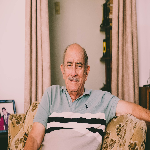

In [ ]:
from io import BytesIO
import requests
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array

url = 'https://www.tzvi.dev/images/headshot_steve_friedman_circle_clear.png'

result = requests.get(url)
test_image = load_img(BytesIO(result.content),target_size=(150,150))
test_image

In [ ]:
image = img_to_array(test_image)
image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
# create a function to decode the predictions
# def decode_predictions(predictions, class_names):
#     results = []
#     for prediction in predictions:
#         result = {class_names[i]: float(prediction[i]) for i in range(len(prediction))}
#         results.append(result)
#     return results


# decode_predictions(predictions, class_names)[0]

dict(zip(train_generator.class_indices.keys(), predictions[0]))
# predictions

1/1 [==============================] - 0s 87ms/step


{'MIDDLE': 0.68539774, 'OLD': 0.002785936, 'YOUNG': 0.31181625}